# This is the SARMIA Model on rainfall data for UAE

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from tqdm import tqdm_notebook
from tqdm.notebook import tqdm
from itertools import product
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
from statsmodels.tsa.seasonal import seasonal_decompose
from matplotlib import pyplot

In [3]:
# Data inputs
# 1. Path where input file is stored
filepath = "C:\CDrive\C_FULL\PHD\Coding Section\Forecasting\Combined Dataset_v2.csv"

# 2. Row number of starting month
startrow_training = 0
endrow_training = 193
startrow_test = 194
endrow_test = 205

# 3. Dependent variable name
dependent_var = "DXB_Daily_Avg_SR"

# 4. PArameter list for SARIMA Grid search
p = range(0, 4, 1)
d = 1
q = range(0, 4, 1)
P = range(0, 4, 1)
D = 1
Q = range(0, 4, 1)
s = 12

In [4]:
df = pd.read_csv(filepath)
df.index.name = 'Month_Year'
df.set_index(df['Month_Year'], inplace=False)
df.head()

,Day,Month,Year,Month_Year,DXB_Daily_Avg_SR
Month_Year,,,,,
0,1,Jan,2003,1-Jan-03,3.4
1,1,Feb,2003,1-Feb-03,3.5
2,1,Mar,2003,1-Mar-03,9.1
3,1,Apr,2003,1-Apr-03,48.9
4,1,May,2003,1-May-03,0.3


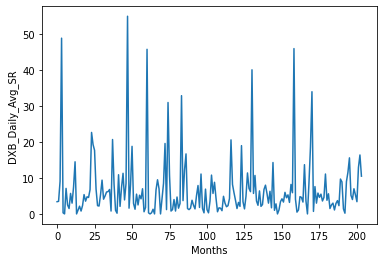

In [5]:
ts=df[dependent_var]
plt.plot(ts)
plt.ylabel(dependent_var)
plt.xlabel('Months')
plt.show()

In [6]:
ts.describe()

count    204.000000
mean       6.746026
std        8.625276
min        0.000000
25%        1.950000
50%        4.200000
75%        7.675000
max       55.000000
Name: DXB_Daily_Avg_SR, dtype: float64

In [7]:
import statsmodels.api as sm

res = sm.tsa.seasonal_decompose(ts,Year)
resplot = res.plot()

NameError: name 'Year' is not defined

<ipython-input-8-963152e703d2>:1: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  result_v1 = seasonal_decompose(ts, model='additive',freq=12)


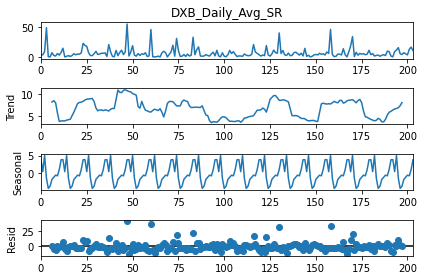

In [8]:
result_v1 = seasonal_decompose(ts, model='additive',freq=12)
result_v1.plot()
pyplot.show()

In [9]:
ts_diff = pd.Series(ts)
dftest = adfuller(ts_diff)
dftest
# Results below show that series is not stationary
# P-value > 5% and ADF statistics is higher than critical values

(-13.949275871189185,
 4.73448073748025e-26,
 0,
 203,
 {'1%': -3.462980134086401,
  '5%': -2.875885461947131,
  '10%': -2.5744164898444515},
 1333.682470324456)

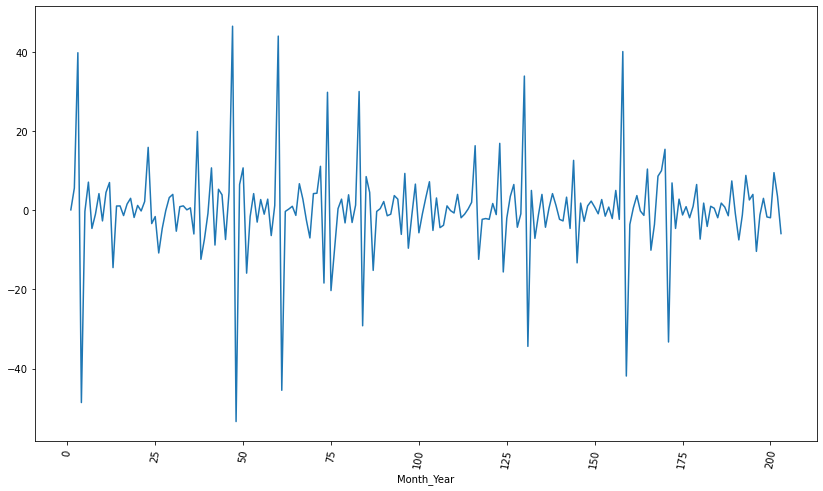

In [10]:
df['Dependent_var_diff1'] = df[dependent_var] - df[dependent_var].shift(1)
df['Dependent_var_diff1'].plot(rot = 80, figsize = (14,8));

In [11]:
ts1  = df['Dependent_var_diff1']
ts_diff1 = pd.Series(ts1)
dftest1 = adfuller(ts_diff1.dropna())
dftest1
# Differenced Time series is stationary: P-value < 5% and ADF statistic lower than critical values

(-8.356412618519496,
 2.901091870559212e-13,
 12,
 190,
 {'1%': -3.4652439354133255,
  '5%': -2.8768752281673717,
  '10%': -2.574944653739612},
 1346.688684660605)

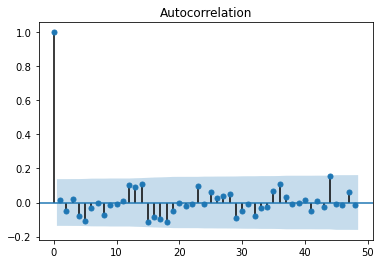

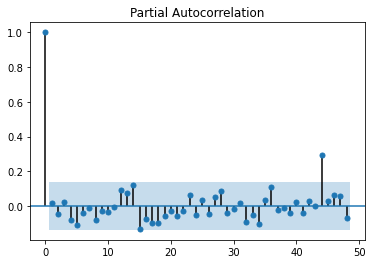

In [12]:
plot_acf(ts, lags = 48)
plot_pacf(ts, lags = 48)
plt.show()

In [13]:
# Divide the data into train and test datasets
train = df[dependent_var][startrow_training:endrow_training]
test = df[dependent_var][startrow_test:endrow_test]
train

Month_Year
0       3.4
1       3.5
2       9.1
3      48.9
4       0.3
       ... 
188     2.3
189     9.7
190     8.9
191     1.4
192     0.2
Name: DXB_Daily_Avg_SR, Length: 193, dtype: float64

In [14]:
test

Month_Year
194    11.6
195    15.6
196     5.2
197     4.0
198     7.0
199     5.3
200     3.4
201    12.9
202    16.4
203    10.5
Name: DXB_Daily_Avg_SR, dtype: float64

In [15]:
def optimize_sarima(parameters_list, d, D, s, data) :
    results = []
    
    for param in tqdm(parameters_list):
        try:
            model = SARIMAX(data, order=(param[0], d, param[1]),seasonal_order=(param[2], D, param[3], s),enforce_stationarity=False, enforce_invertibility=False).fit()
        except:
            continue
            
        aic = model.aic
        results.append([param, aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)x(P,Q)', 'AIC']
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [16]:
parameters = product(p, q, P, Q)
parameters_list = list(parameters)
print(len(parameters_list))

256


In [16]:
warnings.simplefilter('ignore', ConvergenceWarning)
result_df = optimize_sarima(parameters_list, d, D, s, train)
result_df

,"(p,q)x(P,Q)",AIC
0,"(3, 3, 3, 3)",1003.370526
1,"(2, 3, 3, 3)",1004.180812
2,"(3, 3, 2, 3)",1005.916450
3,"(0, 3, 2, 3)",1010.086202
4,"(1, 3, 2, 3)",1010.273907
...,...,...
251,"(0, 0, 1, 0)",1397.120074
252,"(3, 0, 0, 0)",1397.919289
253,"(2, 0, 0, 0)",1429.785355
254,"(1, 0, 0, 0)",1477.688699


In [18]:
# Selected 4th set of parameters from the grid search above because of 2 reasons:
# 1. intuitively so that it is in line with the observations from ACF and PACF plots
# 2. This set gave better MAPE and RMSE for small difference in AIC values compared to first few cases
model_final = SARIMAX(train, order=(2, 1, 1),seasonal_order=(3, 1, 1, 12),enforce_stationarity=False, enforce_invertibility=False).fit()
aic_final = model_final.aic
aic_final

1030.7974012879297

In [19]:
fcast = model_final.get_prediction(start=1, end=len(train))
solarradiation_predict = fcast.predicted_mean
solarradiation_ci = fcast.conf_int()

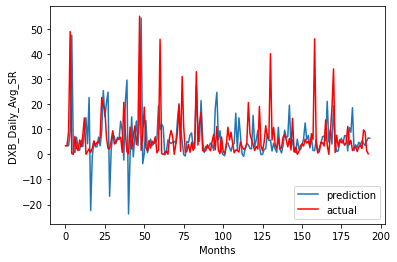

In [20]:
plt.plot(solarradiation_predict,label='prediction')
plt.plot(train,color='red',label='actual')
plt.ylabel(dependent_var)
plt.xlabel('Months')
plt.legend()
plt.show()

In [21]:
print(model_final.summary())

                                     SARIMAX Results                                      
Dep. Variable:                   DXB_Daily_Avg_SR   No. Observations:                  193
Model:             SARIMAX(2, 1, 1)x(3, 1, 1, 12)   Log Likelihood                -507.399
Date:                            Mon, 18 Jan 2021   AIC                           1030.797
Time:                                    06:11:50   BIC                           1054.444
Sample:                                         0   HQIC                          1040.406
                                            - 193                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0722      0.092     -0.787      0.431      -0.252       0.108
ar.L2         -0.0293      0.116   

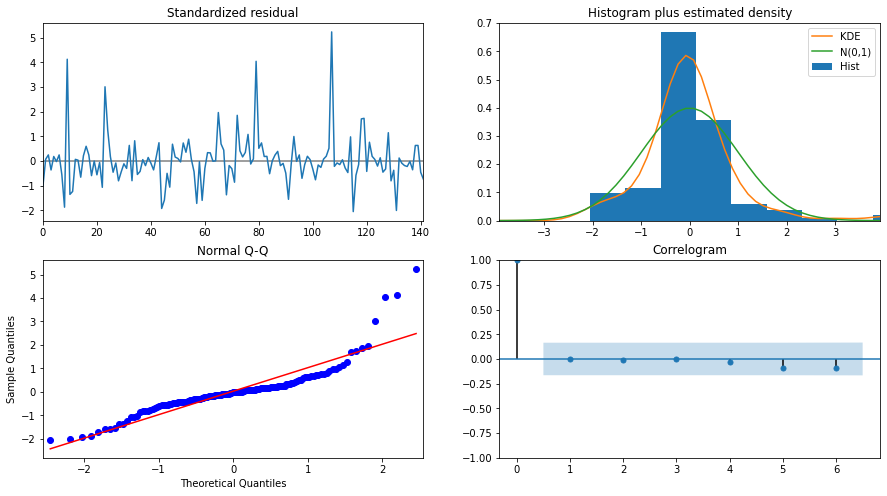

In [22]:
model_final.plot_diagnostics(lags=6,figsize=(15,8));

In [23]:
def forecast_accuracy(forecast, actual):
   
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
 
    
    return({ 'me':me, 'mae': mae, 
            })

forecast_accuracy(solarradiation_predict, train)

{'me': -0.2028402524986954, 'mae': 6.849776730584203}

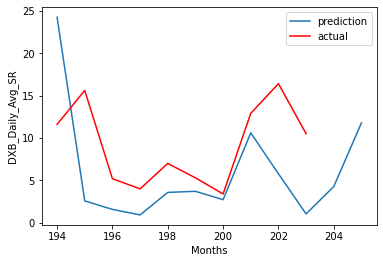

In [23]:
# Forecast the values for validation dataset and check if the model generalizes well
#fcast_test = model_final.get_prediction(start=72, end=95)
fcast_test = model_final.get_prediction(start=194, end=205)
solarradiation_predict_test = fcast_test.predicted_mean
solarradiation_ci_test = fcast_test.conf_int()
plt.plot(solarradiation_predict_test,label='prediction')
plt.plot(test,color='red',label='actual')
plt.ylabel(dependent_var)
plt.xlabel('Months')
plt.legend()
plt.show()